# Banknote Authentication Project

Aim of this project is to implement KNN algorithm using famious banknote authentication data set. Wavelet transformation tools were used to extract descriptive features of genuine and counterfeit banknote images. Dataset consists of 4 numeric features and the target. 

Following steps will be applied:
1. Describe data
2. Vizualize data
3. Model and feature selection
4. Evaluate selected model
5. Vizualize decision regions

In [1]:
#Loding libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import classification_report,confusion_matrix

%matplotlib inline
plt.style.use('seaborn-white')

## Read and Describe data
Lets read and describe our data using pandas.
1. Read comma delimeted text file using read_csv method   
2. Check first few lines with head method   
3. Get information about shape of data,feature types,null values
4. Gain more intuition by looking at some desctiptive statistics

In [2]:
df = pd.read_csv('data/data_banknote_authentication.txt',delimiter=',')
#df = df.sample(frac=1).reset_index(drop=True) #Shuffle rows if needed

In [3]:
df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
variance    1372 non-null float64
skewness    1372 non-null float64
curtosis    1372 non-null float64
entropy     1372 non-null float64
class       1372 non-null int64
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [5]:
df.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


## Vizualize  Data

We will use seaborn and matplotlib for vizualizing our data    

Using countplot we can see number of observations in each class. We have enough observations for each class.

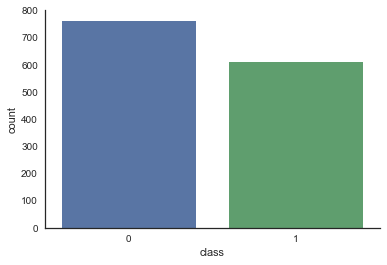

In [6]:
sns.countplot(data=df,x='class')
sns.despine()

Lets check distribution of features by using boxplot. We can see that depending on target class distribution of features changes. This is good indicator for classification tasks. 
There are some outliers in out data. But for now we will keep them in our data (as some variance values are negative we assume preprocessing already applied). Also note that sometimes outliers can be valuable for classification tasks.

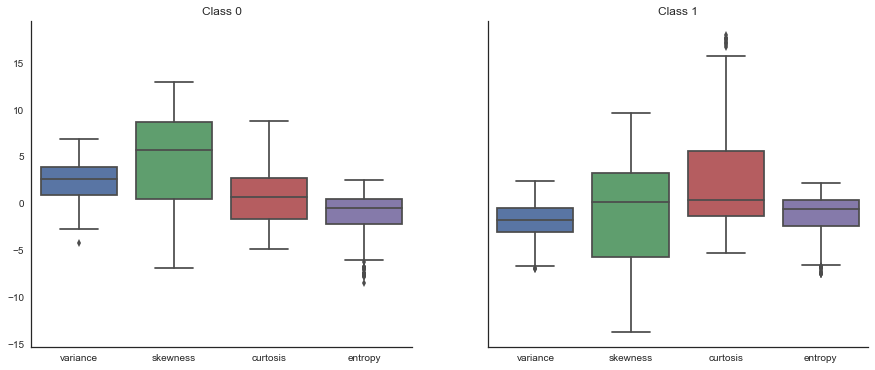

In [7]:
f,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,6),sharey=True)
for i in range(2):
    sns.boxplot(data=df[df['class']==i].drop('class',axis=1),ax=ax[i])
    ax[i].set_title('Class {}'.format(i))
sns.despine()

Now we can combine histogram and KDE plots for each feature usin distplot method of seaborn. Again we can clearly see that some features have more effect on classification. Variance has more power while entropy the least.

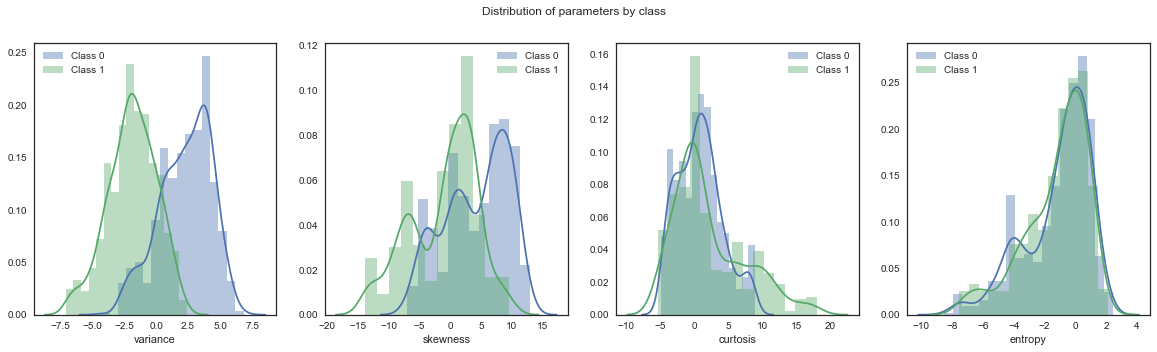

In [8]:
f,ax=plt.subplots(nrows=1,ncols=4,figsize=(20,5))
for i,col in enumerate(df.columns[:4]):
    sns.distplot(df[df['class']==0][col],ax=ax[i],label='Class 0')
    sns.distplot(df[df['class']==1][col],ax=ax[i],label='Class 1')
    ax[i].legend()
f.suptitle('Distribution of parameters by class');

This time we use PairGrid distribution of target variables for each pair of features. Note that kde and scatter plots are used to give more intuitution about data. None of the features perfectly seperate classes from each other. But we will see that each of them has an effect on final classification result.

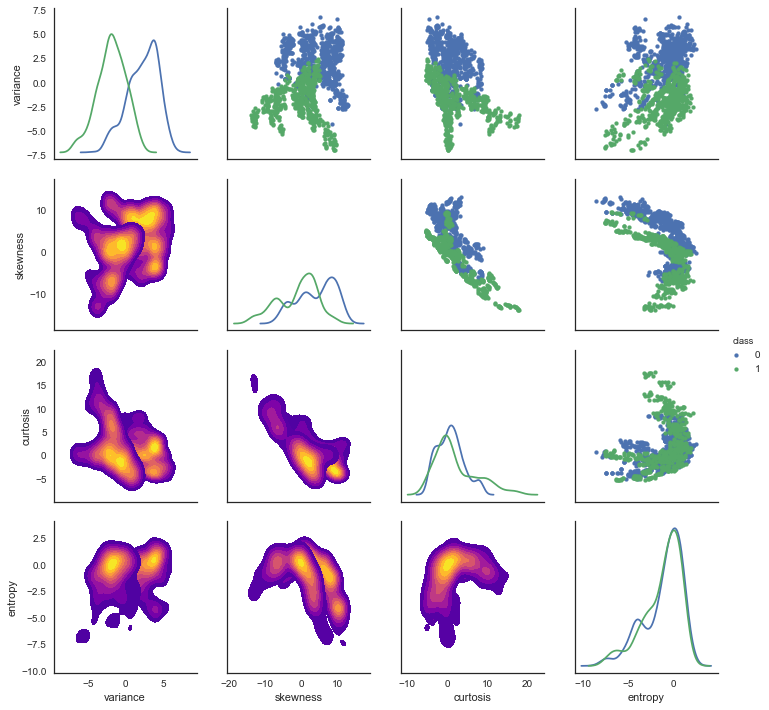

In [9]:
g = sns.PairGrid(data=df,hue='class',x_vars=df.columns[:4],y_vars=df.columns[:4])
g.map_upper(plt.scatter,s=15)
g.map_lower(sns.kdeplot,shade=True, shade_lowest=False,cmap='plasma')
g.map_diag(sns.kdeplot)
g.add_legend()
plt.show()

By using heatmap we can vizualize correlation between features and target. We can see that some features are higly correlated. Feature engineering activities can be performed to create new features and remove redundant data. But for now we will skip this part.

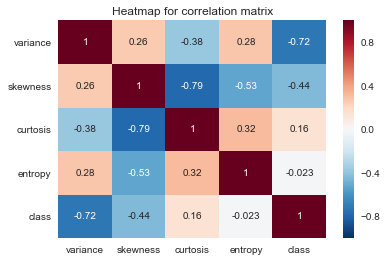

In [10]:
sns.heatmap(df.corr(),annot=True)
plt.gca().set_title('Heatmap for correlation matrix')
plt.show()

## Implementing  KNN Classifier

Now it is time to implement KNN Classifier with sklearn. We will look at effect of different combinations of features and K values. There are different techniques for feature selection which are available in sklearn. But we will implement simplified Forward Selection method to choose best combination of features. For each combination of features different models will be evaluated by changing K value. For selecting best model we are going to use 10 Fold Cross Validation. Many different metrics exists for checking model accuracy. We will use f1 as a scoring metric. Result for each step is added to dataframe for vizualisation.

In [11]:
features = ['variance','skewness','curtosis','entropy']
result = []
for param,_ in enumerate(features):
    for k in range(1,41,2):
        knn = KNeighborsClassifier(n_neighbors=k)
        selected_f = features[:param+1]
        cv_score = cross_val_score(knn,df[selected_f],df['class'],cv=10,scoring='f1').mean()
        result.append({'k':k,'features':','.join(selected_f),'score':cv_score})
result = pd.DataFrame(result)        

Below you can see result of different models. For the model with single parameter increasing K value has positive effect on model accuracy and we get maximum score when K=29. By adding features we can increase accuracy of our model. But for K=5 we can seee that there is no difference between models with all and 3 features. For simplicity we can ingnore entropy feature (which is directly realeted with other features) and use model with 3 features and K=5. 

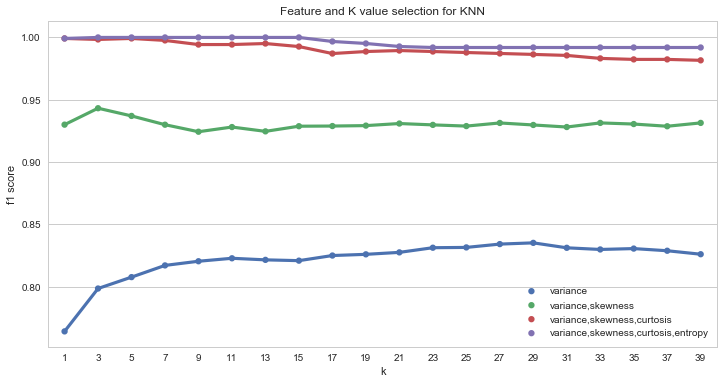

In [12]:
sns.set_style('whitegrid')
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))
sns.pointplot(x='k',y='score',hue='features',data=result,markers='.',ax=ax)
ax.set_ylabel('f1 score')
ax.set_title('Feature and K value selection for KNN')
plt.legend()
plt.show()

Below we can check classification report and confusion matrix for selected model.

In [13]:
X_train,X_test,y_train,y_test = train_test_split(df[features[:4]],df['class'],test_size=0.3)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
predictions = knn.predict(X_test)
print('Classification report:\n',classification_report(y_test,predictions))
print('Confusion matrix:\n',confusion_matrix(y_test,predictions))

Classification report:
              precision    recall  f1-score   support

          0       1.00      1.00      1.00       234
          1       1.00      1.00      1.00       178

avg / total       1.00      1.00      1.00       412

Confusion matrix:
 [[234   0]
 [  0 178]]


As a final step we will draw decision regions for model with two parameters

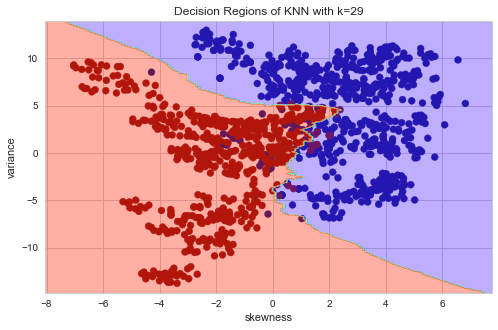

In [14]:
# choose 2 features
features = ['variance','skewness']

# Plotting decision regions
x_min, x_max = df.loc[:, features[0]].min() - 1, df.loc[:, features[0]].max() + 1
y_min, y_max = df.loc[:, features[1]].min() - 1, df.loc[:, features[1]].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

knn = KNeighborsClassifier(n_neighbors=29)
knn.fit(X_train[features],y_train)

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,5))
plt.scatter(df.loc[:, features[0]], df.loc[:, features[1]], c=df['class'],  cmap='jet')
plt.contourf(xx, yy, Z, alpha=0.4,cmap='rainbow')
ax.set_ylabel(features[0])
ax.set_xlabel(features[1])
_=ax.set_title('Decision Regions of KNN with k=29')